In [1]:
#라이브러리 import 
import torch.distributed as dist #분산학습을 위한 라이브러리
import torch.optim as optim #옵티마이져

import torch.optim.lr_scheduler as lr_scheduler

import test  # import test.py to get mAP after each epoch
from models import *
from utils.datasets import *
from utils.utils import *

In [2]:
# mixed_precision : 여러 precision 연산이 가능한 것을 의미/ 한사이클 내에서
mixed_precision = True

# mixed_precision을 지원하는 NVIDIA의 Library
from apex import amp

In [3]:
# 가중치
wdir = 'weights' + os.sep
last = wdir + 'last.pt'
best = wdir + 'best.pt'
results_file = 'results.txt'

In [4]:
#하이퍼 파라미터 값
hyp = {'giou': 1.582,  # giou loss gain
       'cls': 27.76,  # cls loss gain  (CE=~1.0, uCE=~20)
       'cls_pw': 1.446,  # cls BCELoss positive_weight
       'obj': 21.35,  # obj loss gain (*=80 for uBCE with 80 classes)
       'obj_pw': 3.941,  # obj BCELoss positive_weight
       'iou_t': 0.2635,  # iou training threshold
       'lr0': 1e-5,  # initial learning rate (SGD=1E-3, Adam=9E-5)
       'lrf': -5.,  # final LambdaLR learning rate = lr0 * (10 ** lrf)
       'momentum': 0.97,  # SGD momentum
       'weight_decay': 5e-5,  # optimizer weight decay
       'fl_gamma': 0.5,  # focal loss gamma
       'hsv_s': 0.5703,  # image HSV-Saturation augmentation (fraction)
       'hsv_v': 0.3174,  # image HSV-Value augmentation (fraction)
       'degrees': 1.113,  # image rotation (+/- deg)
       'translate': 0.06797,  # image translation (+/- fraction)
       'scale': 0.1059,  # image scale (+/- gain)
       'shear': 0.5768}  # image shear (+/- deg)

In [5]:
#argument value

epochs = 100
batch_size = 64
accumulate = 1
cfg = 'cfg/fashion.cfg'
data = 'data/fashion/fashion.data'
multi_scale = False
img_size = 416
rect = False
resume = False
transfer = False
nosave = False
notest = False
evolve = False
img_weights = False
cache_images = False
weights =''
arc='defaultpw'
prebias = False
adam = False
device = torch_utils.select_device('', apex=mixed_precision)

Using CUDA Apex device0 _CudaDeviceProperties(name='GeForce RTX 2080', total_memory=7982MB)
                device1 _CudaDeviceProperties(name='GeForce RTX 2080', total_memory=7982MB)
                device2 _CudaDeviceProperties(name='GeForce RTX 2080', total_memory=7982MB)
                device3 _CudaDeviceProperties(name='GeForce RTX 2080', total_memory=7982MB)



In [6]:
#Configure run
data_dict = parse_data_cfg(data)
train_path = data_dict['train']
nc = int(data_dict['classes']) #9
data_dict

{'classes': '9',
 'train': './data/fashion/trainvalno5k.txt',
 'valid': './data/fashion/5k.txt',
 'names': './data/fashion/fashion.names',
 'backup': 'backup/',
 'eval': 'coco'}

In [7]:
# Initialize model
model = Darknet(cfg, arc=arc)
#model load and move to gpu

In [8]:
pg0, pg1 = [], []  # optimizer parameter groups
for k, v in dict(model.named_parameters()).items():
    if 'Conv2d.weight' in k:
        pg1 += [v]  # parameter group 1 (apply weight_decay)/ conv2d 가중치 L2정규화
    else:
        pg0 += [v]  # parameter group 0

In [9]:
optimizer = optim.SGD(pg0, lr=hyp['lr0'], momentum=hyp['momentum'], nesterov=True)

#this can be useful when fine tuning a pre-trained network as frozen layers can be made trainable and added to the Optimizer as training progresses.
optimizer.add_param_group({'params': pg1, 'weight_decay': hyp['weight_decay']})  
# originally weight decay = 0
# add pg1 with weight_decay

del pg0, pg1

In [10]:
cutoff = -1  # backbone reaches to cutoff layer
start_epoch = 0
best_fitness = 0.
attempt_download(weights)

In [11]:
scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=[round(epochs * x) for x in [0.8, 0.9]], gamma=0.1)
#지정된 epoch에만 gamma 비율로 감소시킨다.
scheduler.last_epoch = start_epoch - 1

In [14]:
if mixed_precision:
    # amp.initialize를 통해 초기화
    print('mixed precision')
    model, optimizer = amp.initialize(model, optimizer, opt_level='O1', verbosity=0)

mixed precision


In [15]:
# Initialize distributed training
# 4개의 gpu가 돌아가기 시작
if torch.cuda.device_count() > 1:
    dist.init_process_group(backend='nccl',  # 'distributed backend'
                            init_method='tcp://127.0.0.1:9998',  # distributed training init method
                            world_size=1,  # number of nodes for distributed training
                            rank=0)  # distributed training node rank
    model = torch.nn.parallel.DistributedDataParallel(model)
    model.yolo_layers = model.module.yolo_layers  # move yolo layer indices to top level

In [12]:
# Dataset
dataset = LoadImagesAndLabels(train_path,
                              img_size,
                              batch_size,
                              augment=True,
                              hyp=hyp,  # augmentation hyperparameters
                              rect=rect,  # rectangular training
                              image_weights=img_weights,
                              cache_labels=True if epochs > 10 else False,
                              cache_images=False if prebias else cache_images)

Reading labels (104264 found, 0 missing, 0 empty for 104264 images): 100%|██████████| 104264/104264 [03:39<00:00, 475.00it/s] 


In [39]:
dataset.__getitem__(0)

(tensor([[[0.71765, 0.71373, 0.71373,  ..., 0.39216, 0.39216, 0.39216],
          [0.71765, 0.71765, 0.72157,  ..., 0.39608, 0.39608, 0.39216],
          [0.72157, 0.72941, 0.73725,  ..., 0.40392, 0.39608, 0.38824],
          ...,
          [0.76078, 0.75686, 0.73333,  ..., 0.72157, 0.72549, 0.72549],
          [0.75294, 0.74902, 0.73333,  ..., 0.73725, 0.73725, 0.74118],
          [0.72941, 0.73333, 0.73333,  ..., 0.74118, 0.74510, 0.75686]],
 
         [[0.70588, 0.70196, 0.70196,  ..., 0.35294, 0.35294, 0.35294],
          [0.70588, 0.70588, 0.70980,  ..., 0.35686, 0.35686, 0.35294],
          [0.70980, 0.71765, 0.72549,  ..., 0.36471, 0.35686, 0.34902],
          ...,
          [0.75294, 0.74902, 0.72549,  ..., 0.71373, 0.71765, 0.70980],
          [0.74510, 0.74118, 0.72549,  ..., 0.72941, 0.72941, 0.72941],
          [0.72157, 0.72549, 0.72549,  ..., 0.73333, 0.73725, 0.74510]],
 
         [[0.67451, 0.67059, 0.67059,  ..., 0.31765, 0.31765, 0.31765],
          [0.67451, 0.67843,

In [40]:
# Dataloader
dataloader = torch.utils.data.DataLoader(dataset,
                                         batch_size=batch_size,
                                         num_workers=min([os.cpu_count(), batch_size, 16]),
                                         shuffle=True,  # Shuffle=True unless rectangular training is used
                                         pin_memory=True,
                                         collate_fn=dataset.collate_fn #sampler = train_sampler
                                        )

# dataloader가 실행되면 배치사이즈만큼 원래 이미지 배열, 라벨 값, 파일 위치, 이미지 크기가 출력된다.

In [17]:
#start  training
model.nc = nc
model.arc = arc
model.hyp = hyp
model_info(model, report='summary')
nb = len(dataloader)
maps = np.zeros(nc)
results = (0, 0, 0, 0, 0, 0, 0)  
# 'P', 'R', 'mAP', 'F1', 'val GIoU', 'val Objectness', 'val Classification'
# Precision, Recal, mAP, F1, val GloU, val Objectness, val Classification
tb_writer = None

Model Summary: 222 layers, 6.15668e+07 parameters, 6.15668e+07 gradients


In [19]:
model_info(model, report='full')

layer                                     name  gradient   parameters                shape         mu      sigma
    0                   module.0.Conv2d.weight      True          864        [32, 3, 3, 3]   -0.00216       0.11
    1              module.0.BatchNorm2d.weight      True           32                 [32]          1          0
    2                module.0.BatchNorm2d.bias      True           32                 [32]          0          0
    3                   module.1.Conv2d.weight      True        18432       [64, 32, 3, 3]   8.46e-05     0.0341
    4              module.1.BatchNorm2d.weight      True           64                 [64]          1          0
    5                module.1.BatchNorm2d.bias      True           64                 [64]          0          0
    6                   module.2.Conv2d.weight      True         2048       [32, 64, 1, 1]   0.000304     0.0721
    7              module.2.BatchNorm2d.weight      True           32                 [32]      

  142             module.67.BatchNorm2d.weight      True         1024               [1024]          1          0
  143               module.67.BatchNorm2d.bias      True         1024               [1024]          0          0
  144                  module.69.Conv2d.weight      True       524288    [512, 1024, 1, 1]  -2.99e-05      0.018
  145             module.69.BatchNorm2d.weight      True          512                [512]          1          0
  146               module.69.BatchNorm2d.bias      True          512                [512]          0          0
  147                  module.70.Conv2d.weight      True  4.71859e+06    [1024, 512, 3, 3]   1.23e-06    0.00851
  148             module.70.BatchNorm2d.weight      True         1024               [1024]          1          0
  149               module.70.BatchNorm2d.bias      True         1024               [1024]          0          0
  150                  module.72.Conv2d.weight      True       524288    [512, 1024, 1, 1]   1.0

In [65]:
epoch = 0
idx = 0
for i, (imgs, targets, paths, _) in pbar:
    idx += 1
    print('idx',idx)
    if idx > 1 :
        break
    ni = i + nb * epoch
    imgs = imgs.to(device)
    print(imgs)
    targets = targets.to(device)
    print(len(imgs))

  0%|          | 14/6517 [1:06:26<1354:50:47, 750.03s/it]

idx 1
tensor([[[[0.50196, 0.50196, 0.50196,  ..., 0.50196, 0.50196, 0.50196],
          [0.50196, 0.50196, 0.50196,  ..., 0.50196, 0.50196, 0.50196],
          [0.50196, 0.50196, 0.50196,  ..., 0.50196, 0.50196, 0.50196],
          ...,
          [0.50196, 0.50196, 0.50196,  ..., 0.50196, 0.50196, 0.50196],
          [0.50196, 0.50196, 0.50196,  ..., 0.50196, 0.50196, 0.50196],
          [0.50196, 0.50196, 0.50196,  ..., 0.50196, 0.50196, 0.50196]],

         [[0.50196, 0.50196, 0.50196,  ..., 0.50196, 0.50196, 0.50196],
          [0.50196, 0.50196, 0.50196,  ..., 0.50196, 0.50196, 0.50196],
          [0.50196, 0.50196, 0.50196,  ..., 0.50196, 0.50196, 0.50196],
          ...,
          [0.50196, 0.50196, 0.50196,  ..., 0.50196, 0.50196, 0.50196],
          [0.50196, 0.50196, 0.50196,  ..., 0.50196, 0.50196, 0.50196],
          [0.50196, 0.50196, 0.50196,  ..., 0.50196, 0.50196, 0.50196]],

         [[0.50196, 0.50196, 0.50196,  ..., 0.50196, 0.50196, 0.50196],
          [0.50196, 0.50

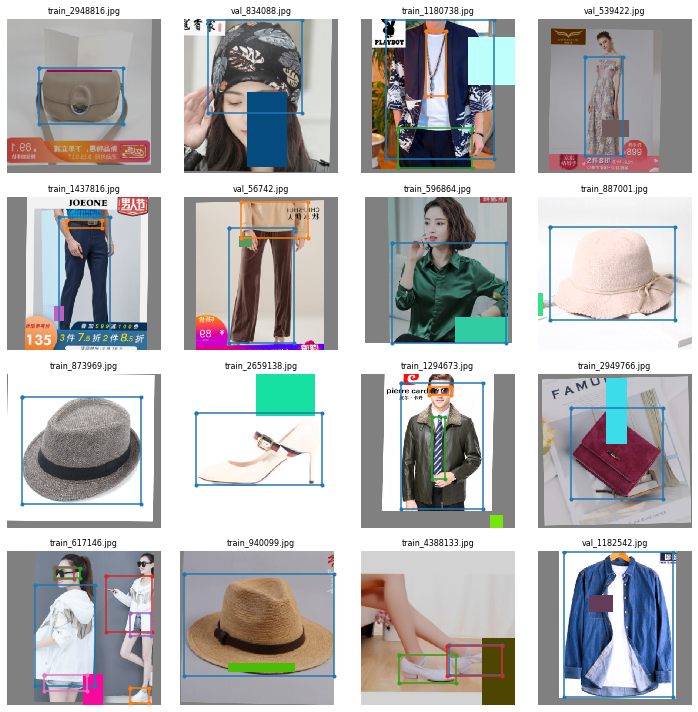

In [66]:
imgs = imgs.cpu().numpy()
targets = targets.cpu().numpy()
# targets = targets[targets[:, 1] == 21]  # plot only one class

fig = plt.figure(figsize=(10, 10))
bs, _, h, w = imgs.shape  # batch size, _, height(416), width(416)
bs = min(bs, 16)  # limit plot to 16 images
ns = np.ceil(bs ** 0.5)  # number of subplots

for i in range(bs):
    boxes = xywh2xyxy(targets[targets[:, 0] == i, 2:6]).T
    #print(boxes)
    boxes[[0, 2]] *= w
    boxes[[1, 3]] *= h
    plt.subplot(ns, ns, i + 1).imshow(imgs[i].transpose(1, 2, 0))
    plt.plot(boxes[[0, 2, 2, 0, 0]], boxes[[1, 1, 3, 3, 1]], '.-')
    plt.axis('off')
    if paths is not None:
        s = Path(paths[i]).name
        plt.title(s[:min(len(s), 40)], fontdict={'size': 8})  # limit to 40 characters
fig.tight_layout()

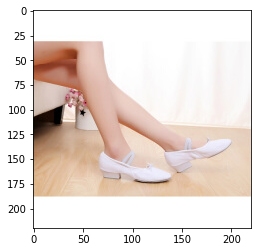

In [67]:
img_path = '/home/piclick/data/fashion_google/images/train/'
txt_path = '/home/piclick/data/fashion_google/labels/train/'
img_name = 'train_4388133'
from PIL import Image

plt.imshow(Image.open(img_path+img_name +'.jpg'))
with open(txt_path +img_name +'.txt') as f:
    txt = f.read()

In [19]:
for epoch in range(start_epoch, epochs):  # epoch ------------------------------------------------------------------
    model.train()
    print(('\n' + '%10s' * 8) % ('Epoch', 'gpu_mem', 'GIoU', 'obj', 'cls', 'total', 'targets', 'img_size'))

    # Freeze backbone at epoch 0, unfreeze at epoch 1 (optional)
    freeze_backbone = False
    if freeze_backbone and epoch < 2:
        for name, p in model.named_parameters():
            if int(name.split('.')[1]) < cutoff:  # if layer < 75
                p.requires_grad = False if epoch == 0 else True

    # Update image weights (optional)
    if dataset.image_weights:
        w = model.class_weights.cpu().numpy() * (1 - maps) ** 2  # class weights
        image_weights = labels_to_image_weights(dataset.labels, nc=nc, class_weights=w)
        dataset.indices = random.choices(range(dataset.n), weights=image_weights, k=dataset.n)  # rand weighted idx

    mloss = torch.zeros(4).to(device)  # mean losses
    pbar = tqdm(enumerate(dataloader), total=nb)  # progress bar
    for i, (imgs, targets, paths, _) in pbar:  # batch -------------------------------------------------------------
        ni = i + nb * epoch  # number integrated batches (since train start)
        imgs = imgs.to(device)
        targets = targets.to(device)

        # Run model
        pred = model(imgs)

        # Compute loss
        loss, loss_items = compute_loss(pred, targets, model)
        if not torch.isfinite(loss):
            print('WARNING: non-finite loss, ending training ', loss_items)
            #return results

        # Scale loss by nominal batch_size of 64
        loss *= batch_size / 64

        # Compute gradient
        if mixed_precision:
            with amp.scale_loss(loss, optimizer) as scaled_loss:
                scaled_loss.backward()
        else:
            loss.backward()

        # Accumulate gradient for x batches before optimizing
        if ni % accumulate == 0:
            optimizer.step()
            optimizer.zero_grad()

        # Print batch results
        mloss = (mloss * i + loss_items) / (i + 1)  # update mean losses
        mem = torch.cuda.memory_cached() / 1E9 if torch.cuda.is_available() else 0  # (GB)
        s = ('%10s' * 2 + '%10.3g' * 6) % (
            '%g/%g' % (epoch, epochs - 1), '%.3gG' % mem, *mloss, len(targets), img_size)
        pbar.set_description(s)

        # end batch ------------------------------------------------------------------------------------------------

    # Update scheduler
    scheduler.step()

    # Process epoch results
    final_epoch = epoch + 1 == epochs
    if prebias:
        print_model_biases(model)
    else:
        # Calculate mAP (always test final epoch, skip first 10 if opt.nosave)
        if not (notest or (nosave and epoch < 10)) or final_epoch:
            with torch.no_grad():
                results, maps = test.test(cfg,
                                          data,
                                          batch_size=batch_size,
                                          img_size=img_size,
                                          model=model,
                                          conf_thres=0.001 if final_epoch and epoch > 0 else 0.1,  # 0.1 for speed
                                          save_json=final_epoch and epoch > 0 and 'coco.data' in data)

    # Write epoch results
    with open(results_file, 'a') as f:
        f.write(s + '%10.3g' * 7 % results + '\n')  # P, R, mAP, F1, test_losses=(GIoU, obj, cls)

    # Write Tensorboard results
    if tb_writer:
        x = list(mloss) + list(results)
        titles = ['GIoU', 'Objectness', 'Classification', 'Train loss',
                  'Precision', 'Recall', 'mAP', 'F1', 'val GIoU', 'val Objectness', 'val Classification']
        for xi, title in zip(x, titles):
            tb_writer.add_scalar(title, xi, epoch)

    # Update best mAP
    fitness = results[2]  # mAP
    if fitness > best_fitness:
        best_fitness = fitness

    # Save training results
    save = (not nosave) or (final_epoch and not evolve) or prebias
    if save:
        with open(results_file, 'r') as f:
            # Create checkpoint
            chkpt = {'epoch': epoch,
                     'best_fitness': best_fitness,
                     'training_results': f.read(),
                     'model': model.module.state_dict() if type(
                         model) is nn.parallel.DistributedDataParallel else model.state_dict(),
                     'optimizer': None if final_epoch else optimizer.state_dict()}

        # Save best checkpoint
        if best_fitness == fitness:
            torch.save(chkpt, best)

        # Save backup every 10 epochs (optional)
        if epoch > 0 and epoch % 10 == 0:
            torch.save(chkpt, wdir + 'backup%g.pt' % epoch)

        # Delete checkpoint
        del chkpt

    # end epoch ----------------------------------------------------------------------------------------------------



     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size



  0%|          | 0/1630 [00:00<?, ?it/s]

torch.Size([64, 3, 416, 416])
torch.Size([64, 3, 416, 416])
torch.Size([16, 3, 416, 416])
torch.Size([16, 3, 416, 416])
torch.Size([16, 3, 416, 416])
torch.Size([16, 3, 416, 416])


RuntimeError: Caught RuntimeError in replica 0 on device 0.
Original Traceback (most recent call last):
  File "/root/anaconda3/envs/sypark/lib/python3.6/site-packages/torch/nn/parallel/parallel_apply.py", line 60, in _worker
    output = module(*input, **kwargs)
  File "/root/anaconda3/envs/sypark/lib/python3.6/site-packages/torch/nn/modules/module.py", line 547, in __call__
    result = self.forward(*input, **kwargs)
  File "/storage/home/piclick/jinwoo/yolov3/models.py", line 226, in forward
    x = module(x)
  File "/root/anaconda3/envs/sypark/lib/python3.6/site-packages/torch/nn/modules/module.py", line 547, in __call__
    result = self.forward(*input, **kwargs)
  File "/root/anaconda3/envs/sypark/lib/python3.6/site-packages/torch/nn/modules/container.py", line 92, in forward
    input = module(input)
  File "/root/anaconda3/envs/sypark/lib/python3.6/site-packages/torch/nn/modules/module.py", line 547, in __call__
    result = self.forward(*input, **kwargs)
  File "/root/anaconda3/envs/sypark/lib/python3.6/site-packages/torch/nn/modules/conv.py", line 343, in forward
    return self.conv2d_forward(input, self.weight)
  File "/root/anaconda3/envs/sypark/lib/python3.6/site-packages/torch/nn/modules/conv.py", line 340, in conv2d_forward
    self.padding, self.dilation, self.groups)
  File "/home/piclick/jinwoo/apex/apex/amp/wrap.py", line 28, in wrapper
    return orig_fn(*new_args, **kwargs)
RuntimeError: CUDA out of memory. Tried to allocate 44.00 MiB (GPU 0; 7.80 GiB total capacity; 6.70 GiB already allocated; 31.50 MiB free; 180.76 MiB cached)
